In [ ]:
import glob
import matplotlib.pyplot as plt
import monai
import nibabel as nib
import numpy as np
import os
import random
import torch

from matplotlib.colors import LinearSegmentedColormap
from torch.utils.data import Dataset, DataLoader

from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
)

import sys
sys.path.append("..")
from tinysam import sam_model_registry, SamPredictor

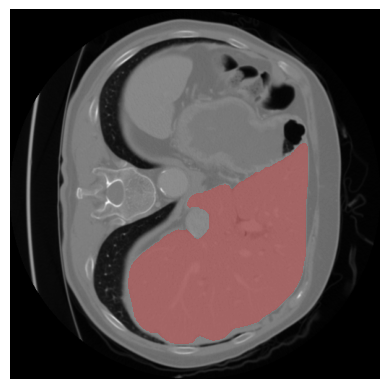

In [3]:
# Test image and label loading
image = nib.load('/datasets/FLARE_2022/images/FLARE22_Tr_0001.nii.gz')
label = nib.load('/datasets/FLARE_2022/labels/FLARE22_Tr_0001.nii.gz')

gt_mask = label.get_fdata() == 1

colors = [(0, 0, 0, 0), (1, 0, 0, 1)]
binary_cmap = LinearSegmentedColormap.from_list('custom_binary', colors, N=2)

slice = 70
plt.imshow(image.get_fdata()[:,:,slice], cmap='gray')
plt.imshow(gt_mask[:,:,slice], cmap=binary_cmap, alpha=0.25)
plt.axis('off')
plt.show()

Handle Dataset

In [4]:
class FlareDataset(Dataset):
    def __init__(self, root_dir, organ_label="all"):
        self.root_dir = root_dir
        self.img_path = os.path.join(root_dir, "images")
        self.gt_path = os.path.join(root_dir, "labels")
        self.gt_path_files = sorted(
            glob.glob(os.path.join(self.gt_path, "*.nii.gz"))
        )
        self.organ_num = {
            'all': 0,
            'liver': 1,
            'right_kidney': 2,
            'spleen': 3,
            'pancreas': 4,
            'aorta': 5,
            'ivc': 6,
            'rag': 7,
            'lag': 8,
            'gallbladder': 9,
            'esophagus': 10,
            'stomach': 11,
            'duodenum': 12,
            'left_kidney': 13
        }[organ_label]

    def __len__(self):
        return len(self.gt_path_files)
    
    def __getitem__(self, index):

        img_name = os.path.basename(self.gt_path_files[index])
        # Load image
        img_path = os.path.join(self.img_path, img_name)
        image_nifti = nib.load(img_path).get_fdata()
        
        # Load gt
        gt_path = os.path.join(self.gt_path, img_name)
        gt = nib.load(gt_path).get_fdata()
        if (self.organ_num == 0):
            label_ids = np.unique(gt)[1:]   
            gt_mask = np.uint8(gt == random.choice(label_ids.tolist()))
        else:
            gt_mask = np.uint8(gt == self.organ_num)

        return (
            torch.tensor(image_nifti).float(),
            torch.tensor(gt_mask).float()
        )

In [5]:
root_dir = "/datasets/FLARE_2022/"
sample_ds = FlareDataset(root_dir, organ_label='all')
sample_loader = DataLoader(sample_ds, batch_size=1, shuffle=True)

In [7]:
device = torch.device('cuda:0')
num_epochs = 1

student = sam_model_registry["vit_t"]()
student.to(device=device)

medsam = sam_model_registry['vit_b'](checkpoint='weights/medsam_vit_b.pth')
medsam = medsam.to(device)
medsam.eval()

optimizer = torch.optim.Adam(student.mask_decoder.parameters())